# Analyzing NYC's 311 Street Flooding Complaints from 2010 to 2020
## Streets with the Most Street Flooding Complaints

Author: Mark Bauer

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import geopandas as gpd

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

Printing verions of Python modules and packages with **watermark** - the IPython magic extension.  
Documention for installing watermark: https://github.com/rasbt/watermark

In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,geopandas,matplotlib,seaborn

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.6.0

numpy     : 1.23.4
pandas    : 1.5.1
geopandas : 0.12.1
matplotlib: 3.6.2
seaborn   : 0.12.1



# Read in Data

In [3]:
# list items in data folder
%ls data/

README.md                               streets-clipped.gpkg
street-flooding-complaints-cleaned.csv  streets.gpkg
street-flooding-complaints.csv          water-main-breaks.csv


## Street Flooding Complaints

In [4]:
# read data as a dataframe
path = 'data/street-flooding-complaints-cleaned.csv'
df = pd.read_csv(path, low_memory=False)

# preview data
print(f'shape of data: {df.shape}')
df.head()

shape of data: (24817, 27)


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,cross_street_1,cross_street_2,address_type,...,incident_zip,city,x_coordinate_state_plane,y_coordinate_state_plane,latitude,longitude,location,incident_address,street_name,bbl
0,34783066,2016-11-15T09:27:00.000,2016-11-15T10:05:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),NaN,NaN,INTERSECTION,...,10301.0,STATEN ISLAND,958594.0,170855.0,40.635597,-74.092438,"{'latitude': '40.635596930697716', 'longitude'...",NaN,NaN,NaN
1,36178846,2017-05-13T14:41:00.000,2017-11-08T11:05:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),32 AVE,78 ST,INTERSECTION,...,11370.0,East Elmhurst,1014871.0,215198.0,40.757292,-73.889472,"{'latitude': '40.75729226742685', 'longitude':...",NaN,NaN,NaN
2,31360389,2015-08-21T05:46:00.000,2015-08-26T10:27:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),110 AVE,110 RD,ADDRESS,...,11433.0,JAMAICA,1043288.0,192114.0,40.693788,-73.787102,"{'latitude': '40.69378840426638', 'longitude':...",110-07 164 PLACE,164 PLACE,4.101930e+09
3,32686230,2016-02-15T13:10:00.000,2016-02-16T14:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),ALDUS ST,HOE AVE,INTERSECTION,...,10459.0,BRONX,1014578.0,239190.0,40.823145,-73.890421,"{'latitude': '40.82314481234778', 'longitude':...",NaN,NaN,NaN
4,41495135,2019-01-23T11:59:00.000,2019-01-28T13:05:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),102 ST,DEAD END,ADDRESS,...,11414.0,HOWARD BEACH,1031172.0,179312.0,40.658722,-73.830883,"{'latitude': '40.65872239939313', 'longitude':...",102-20 160 AVENUE,160 AVENUE,4.142340e+09


In [5]:
# column info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24817 entries, 0 to 24816
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   unique_key                      24817 non-null  int64  
 1   created_date                    24817 non-null  object 
 2   closed_date                     24816 non-null  object 
 3   agency                          24817 non-null  object 
 4   agency_name                     24817 non-null  object 
 5   complaint_type                  24817 non-null  object 
 6   descriptor                      24817 non-null  object 
 7   cross_street_1                  21821 non-null  object 
 8   cross_street_2                  21816 non-null  object 
 9   address_type                    24817 non-null  object 
 10  status                          24817 non-null  object 
 11  resolution_description          24813 non-null  object 
 12  resolution_action_updated_date  

## Neighborhood Tabulation Areas (NTAs)

In [6]:
# importing nta boundaries
url = 'https://data.cityofnewyork.us/resource/9nt8-h7nd.geojson'
nta_gdf = gpd.read_file(url).to_crs(epsg=2263)

# previewing first five rows in data
print(f'shape of data: {nta_gdf.shape}')
nta_gdf.head()

shape of data: (262, 12)


,shape_area,ntaname,cdtaname,shape_leng,boroname,ntatype,nta2020,borocode,countyfips,ntaabbrev,cdta2020,geometry
0,35321204.8204,Greenpoint,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28912.5653122,Brooklyn,0,BK0101,3,047,Grnpt,BK01,"MULTIPOLYGON (((1003059.973 204572.243, 100299..."
1,28854314.555,Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28098.0267744,Brooklyn,0,BK0102,3,047,Wllmsbrg,BK01,"MULTIPOLYGON (((995851.880 203199.535, 995969...."
2,15208960.44,South Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),18250.2804159,Brooklyn,0,BK0103,3,047,SWllmsbrg,BK01,"MULTIPOLYGON (((998047.189 196303.521, 998157...."
3,52266209.4439,East Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),43184.773814,Brooklyn,0,BK0104,3,047,EWllmsbrg,BK01,"MULTIPOLYGON (((1005302.485 199455.944, 100530..."
4,9982321.73877,Brooklyn Heights,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,14312.506134,Brooklyn,0,BK0201,3,047,BkHts,BK02,"MULTIPOLYGON (((986737.292 194249.956, 986678...."


<AxesSubplot: >

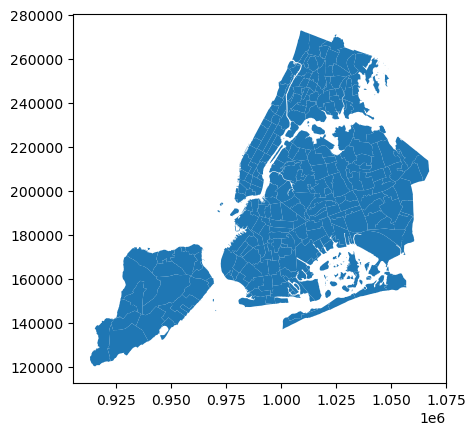

In [7]:
# sanity check plot
nta_gdf.plot()

## Streets

In [8]:
# streets path
path = 'data/streets.gpkg'
streets = gpd.read_file(path)

# sanity checks
print(f'shape of data: {streets.shape}')
print(f"street id is unique: {streets['physicalid'].is_unique}")
print(streets.crs)

# preview
streets.head()

shape of data: (99324, 12)
street id is unique: True
epsg:2263


,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry
0,3,BATTERY PL,BATTERY,BATTERY PL,1,Street,42.0,13,13,1,262.77781228,"MULTILINESTRING ((979278.595 196555.690, 97929..."
1,5,BATTERY PL,BATTERY,BATTERY PL,1,Street,42.0,13,13,1,259.415988519,"MULTILINESTRING ((979377.413 196797.951, 97950..."
2,6,BATTERY PL,BATTERY,BATTERY PL,1,Street,42.0,13,13,1,280.444780871,"MULTILINESTRING ((979503.289 197024.782, 97964..."
3,8,BATTERY PL,BATTERY,BATTERY PL,1,Street,42.0,13,13,1,32.0701391509,"MULTILINESTRING ((979553.746 196059.826, 97952..."
4,14,BATTERY PL,BATTERY,BATTERY PL,1,Street,24.0,13,13,1,206.27185039,"MULTILINESTRING ((980288.092 195963.182, 98026..."


In [9]:
# column info
streets.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 99324 entries, 0 to 99323
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    99324 non-null  object  
 1   st_label      99324 non-null  object  
 2   st_name       99324 non-null  object  
 3   full_stree    99324 non-null  object  
 4   rw_type       99324 non-null  object  
 5   rw_type_name  99324 non-null  object  
 6   st_width      99324 non-null  object  
 7   frm_lvl_co    99324 non-null  object  
 8   to_lvl_co     99324 non-null  object  
 9   borocode      99324 non-null  object  
 10  shape_leng    99324 non-null  object  
 11  geometry      99324 non-null  geometry
dtypes: geometry(1), object(11)
memory usage: 9.1+ MB


In [10]:
# examine counts of geom types
streets.geom_type.value_counts()

MultiLineString    99324
dtype: int64

<AxesSubplot: >

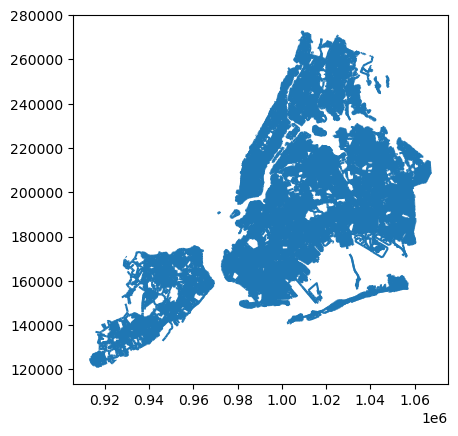

In [11]:
# sanity check plot
streets.plot()

# Assigning NTA (Neighborhood) Information to Street Complaints

In [12]:
# convert to geodataframe from x,y points
crs = 2263
geometry = gpd.points_from_xy(
    df['x_coordinate_state_plane'],
    df['y_coordinate_state_plane']
)

# make geodataframe
gdf = gpd.GeoDataFrame(
    df, 
    geometry=geometry,
    crs=crs
)

# preview geodataframe
gdf.iloc[:, [0, -1]].head()

,unique_key,geometry
0,34783066,POINT (958594.000 170855.000)
1,36178846,POINT (1014871.000 215198.000)
2,31360389,POINT (1043288.000 192114.000)
3,32686230,POINT (1014578.000 239190.000)
4,41495135,POINT (1031172.000 179312.000)


<AxesSubplot: >

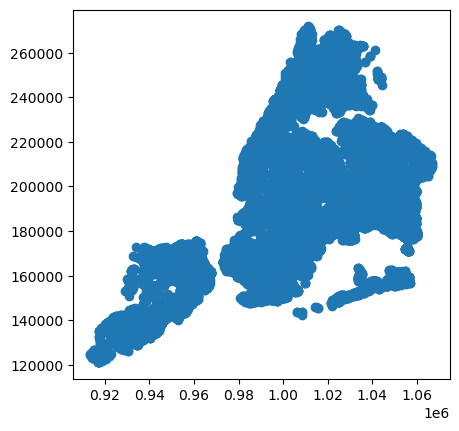

In [13]:
# sanity check plot
gdf.plot()

In [14]:
# spatial join nta to points
gdf = gpd.sjoin(
    gdf,
    nta_gdf,
    how="inner",
    predicate='within'
)

print(f'shape of data: {gdf.shape}')
gdf.head()

shape of data: (24814, 40)


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,cross_street_1,cross_street_2,address_type,...,ntaname,cdtaname,shape_leng,boroname,ntatype,nta2020,borocode,countyfips,ntaabbrev,cdta2020
0,34783066,2016-11-15T09:27:00.000,2016-11-15T10:05:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),NaN,NaN,INTERSECTION,...,St. George-New Brighton,SI01 North Shore (CD 1 Equivalent),31943.5246384,Staten Island,0,SI0101,5,085,StGrg,SI01
926,16585559,2010-05-04T09:20:00.000,2010-05-08T09:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),ST PETER'S PL,BEND,ADDRESS,...,St. George-New Brighton,SI01 North Shore (CD 1 Equivalent),31943.5246384,Staten Island,0,SI0101,5,085,StGrg,SI01
1257,18255249,2010-07-13T13:20:00.000,2010-07-13T15:10:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),ST PETER'S PL,BEND,ADDRESS,...,St. George-New Brighton,SI01 North Shore (CD 1 Equivalent),31943.5246384,Staten Island,0,SI0101,5,085,StGrg,SI01
1341,18380954,2010-07-30T11:08:00.000,2010-07-30T11:20:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),DANIEL LOW TER,BEND,ADDRESS,...,St. George-New Brighton,SI01 North Shore (CD 1 Equivalent),31943.5246384,Staten Island,0,SI0101,5,085,StGrg,SI01
1511,18449016,2010-08-09T13:49:00.000,2010-08-09T14:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),ST PETER'S PL,BEND,ADDRESS,...,St. George-New Brighton,SI01 North Shore (CD 1 Equivalent),31943.5246384,Staten Island,0,SI0101,5,085,StGrg,SI01


In [15]:
# column info
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 24814 entries, 0 to 16453
Data columns (total 40 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   unique_key                      24814 non-null  int64   
 1   created_date                    24814 non-null  object  
 2   closed_date                     24813 non-null  object  
 3   agency                          24814 non-null  object  
 4   agency_name                     24814 non-null  object  
 5   complaint_type                  24814 non-null  object  
 6   descriptor                      24814 non-null  object  
 7   cross_street_1                  21821 non-null  object  
 8   cross_street_2                  21816 non-null  object  
 9   address_type                    24814 non-null  object  
 10  status                          24814 non-null  object  
 11  resolution_description          24810 non-null  object  
 12  resolution

In [16]:
# exclude specified columns
cols = ['shape_leng', 'shape_area', 'index_right']
exclude = gdf.columns.isin(cols)

# locate columns besides ones above
gdf = gdf.loc[:, gdf.columns[~exclude]]

# sanity check
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 24814 entries, 0 to 16453
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   unique_key                      24814 non-null  int64   
 1   created_date                    24814 non-null  object  
 2   closed_date                     24813 non-null  object  
 3   agency                          24814 non-null  object  
 4   agency_name                     24814 non-null  object  
 5   complaint_type                  24814 non-null  object  
 6   descriptor                      24814 non-null  object  
 7   cross_street_1                  21821 non-null  object  
 8   cross_street_2                  21816 non-null  object  
 9   address_type                    24814 non-null  object  
 10  status                          24814 non-null  object  
 11  resolution_description          24810 non-null  object  
 12  resolution

# Snap Complaints to Streets

Methodology: https://medium.com/@brendan_ward/how-to-leverage-geopandas-for-faster-snapping-of-points-to-lines-6113c94e59aa

The code below is from Brendan's awesome post.

In [17]:
# offset of match (ft.)
offset = 80
bbox = gdf.bounds + [-offset, -offset, offset, offset]

# match points to streets based on distance
hits = bbox.apply(lambda row: list(streets.sindex.intersection(row)), axis=1)

print(f'shape of data: {hits.shape}')
hits.head(5)

shape of data: (24814,)


0                     [91978, 43274, 43275]
926     [90144, 36999, 36779, 87014, 87015]
1257    [90144, 36999, 36779, 87014, 87015]
1341                                [36939]
1511    [90144, 36999, 36779, 87014, 87015]
dtype: object

In [18]:
# position1: index of points table
# position2: ordinal position of line - access via iloc later
points_to_lines_dict = {
    'pt_idx': np.repeat(hits.index, hits.apply(len)),
    'line_i': np.concatenate(hits.values)
}
    
tmp = pd.DataFrame(points_to_lines_dict)
# join back to the lines on line_i
# join back to the original points to get their geometry, rename the point geometry as "point"
tmp = (
    tmp
    .join(streets, on="line_i")
    .join(gdf['geometry'].rename("point"), on="pt_idx")
)

print(f'shape of data: {tmp.shape}')
tmp.head()

shape of data: (82780, 15)


,pt_idx,line_i,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,point
0,0,91978.0,170110,LAFAYETTE AVE,LAFAYETTE,LAFAYETTE AVE,1,Street,30.0,13,13,5,275.583357823,"MULTILINESTRING ((958432.654 171078.516, 95859...",POINT (958594.000 170855.000)
1,0,43274.0,52391,BRIGHTON AVE,BRIGHTON,BRIGHTON AVE,1,Street,40.0,13,13,5,115.32307671,"MULTILINESTRING ((958593.707 170854.890, 95851...",POINT (958594.000 170855.000)
2,0,43275.0,52392,BRIGHTON AVE,BRIGHTON,BRIGHTON AVE,1,Street,30.0,13,13,5,172.36564876,"MULTILINESTRING ((958765.405 170839.741, 95859...",POINT (958594.000 170855.000)
3,926,90144.0,163531,RICHMOND TER,RICHMOND,RICHMOND TER,1,Street,34.0,13,13,5,1109.12608333,"MULTILINESTRING ((961854.877 175109.904, 96145...",POINT (960718.000 175485.000)
4,926,36999.0,45130,ST PETERS PL,ST PETERS,ST PETERS PL,1,Street,20.0,13,13,5,263.241339318,"MULTILINESTRING ((960796.937 175434.744, 96073...",POINT (960718.000 175485.000)


In [19]:
# convert back to a GeoDataFrame, so we can do spatial ops
tmp = gpd.GeoDataFrame(
    tmp,
    geometry='geometry',
    crs=gdf.crs
)

print(f'shape of data: {tmp.shape}')
tmp.head()

shape of data: (82780, 15)


,pt_idx,line_i,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,point
0,0,91978.0,170110,LAFAYETTE AVE,LAFAYETTE,LAFAYETTE AVE,1,Street,30.0,13,13,5,275.583357823,"MULTILINESTRING ((958432.654 171078.516, 95859...",POINT (958594.000 170855.000)
1,0,43274.0,52391,BRIGHTON AVE,BRIGHTON,BRIGHTON AVE,1,Street,40.0,13,13,5,115.32307671,"MULTILINESTRING ((958593.707 170854.890, 95851...",POINT (958594.000 170855.000)
2,0,43275.0,52392,BRIGHTON AVE,BRIGHTON,BRIGHTON AVE,1,Street,30.0,13,13,5,172.36564876,"MULTILINESTRING ((958765.405 170839.741, 95859...",POINT (958594.000 170855.000)
3,926,90144.0,163531,RICHMOND TER,RICHMOND,RICHMOND TER,1,Street,34.0,13,13,5,1109.12608333,"MULTILINESTRING ((961854.877 175109.904, 96145...",POINT (960718.000 175485.000)
4,926,36999.0,45130,ST PETERS PL,ST PETERS,ST PETERS PL,1,Street,20.0,13,13,5,263.241339318,"MULTILINESTRING ((960796.937 175434.744, 96073...",POINT (960718.000 175485.000)


In [20]:
# discard any lines that are greater than tolerance from points
# sort on ascending snap distance, so that closest goes to top
tmp["snap_dist"] = tmp['geometry'].distance(gpd.GeoSeries(tmp.point))

tmp = (
    tmp
    .loc[tmp.snap_dist <= offset]
    .sort_values(by=["snap_dist"])
)

# sanity check distance ceiling
tmp.loc[:, ['snap_dist']].describe()

,snap_dist
count,67983.000000
mean,16.063428
std,23.771920
min,0.000003
25%,0.378533
50%,2.738963
75%,28.693191
max,79.996887


In [21]:
# group by the index of the points and take the first, which is the closest line 
closest = (
    tmp
    .groupby("pt_idx")
    .first()
)

# construct a GeoDataFrame of the closest lines
closest = gpd.GeoDataFrame(closest, geometry="geometry")

closest.head()

,line_i,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,point,snap_dist
pt_idx,,,,,,,,,,,,,,,
0,43275.0,52392,BRIGHTON AVE,BRIGHTON,BRIGHTON AVE,1,Street,30.0,13,13,5,172.36564876,"MULTILINESTRING ((958765.405 170839.741, 95859...",POINT (958594.000 170855.000),0.135523
1,27507.0,33544,78 ST,78,78 ST,1,Street,30.0,13,13,4,781.721951111,"MULTILINESTRING ((1014870.958 215198.450, 1014...",POINT (1014871.000 215198.000),0.020164
2,67718.0,83402,164 PL,164,164 PL,1,Street,30.0,13,13,4,431.178187788,"MULTILINESTRING ((1043229.478 192213.204, 1043...",POINT (1043288.000 192114.000),2.996554
3,53494.0,64250,ALDUS ST,ALDUS,ALDUS ST,1,Street,30.0,13,13,2,380.137331178,"MULTILINESTRING ((1014198.807 239165.631, 1014...",POINT (1014578.000 239190.000),0.021552
4,27836.0,33887,160 AVE,160,160 AVE,1,Street,30.0,13,13,4,205.969197341,"MULTILINESTRING ((1031112.252 179304.566, 1031...",POINT (1031172.000 179312.000),4.058630


In [22]:
counts = gdf.shape[0] - closest.shape[0]
counts_perc = round((1 - (closest.shape[0] / gdf.shape[0])) * 100, 2)

msg = f'Dropped {counts} rows or {counts_perc}% of street flooding complaint points, \
which were more than 80 feet from the closest street center line.'

print(msg)

Dropped 64 rows or 0.26% of street flooding complaint points, which were more than 80 feet from the closest street center line.


In [23]:
# position of nearest point from start of the line and get new point location geometry
pos = closest['geometry'].project(gpd.GeoSeries(closest.point))
new_pts = closest['geometry'].interpolate(pos)

# create a new GeoDataFrame from the columns from the closest line and 
# new point geometries (which will be called "geometries")
snapped = gpd.GeoDataFrame(closest, geometry=new_pts)

snapped.head()

,line_i,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,point,snap_dist
pt_idx,,,,,,,,,,,,,,,
0,43275.0,52392,BRIGHTON AVE,BRIGHTON,BRIGHTON AVE,1,Street,30.0,13,13,5,172.36564876,POINT (958593.988 170854.865),POINT (958594.000 170855.000),0.135523
1,27507.0,33544,78 ST,78,78 ST,1,Street,30.0,13,13,4,781.721951111,POINT (1014871.020 215198.003),POINT (1014871.000 215198.000),0.020164
2,67718.0,83402,164 PL,164,164 PL,1,Street,30.0,13,13,4,431.178187788,POINT (1043285.380 192112.545),POINT (1043288.000 192114.000),2.996554
3,53494.0,64250,ALDUS ST,ALDUS,ALDUS ST,1,Street,30.0,13,13,2,380.137331178,POINT (1014578.001 239189.978),POINT (1014578.000 239190.000),0.021552
4,27836.0,33887,160 AVE,160,160 AVE,1,Street,30.0,13,13,4,205.969197341,POINT (1031171.229 179315.985),POINT (1031172.000 179312.000),4.058630


In [24]:
# column info
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 24814 entries, 0 to 16453
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   unique_key                      24814 non-null  int64   
 1   created_date                    24814 non-null  object  
 2   closed_date                     24813 non-null  object  
 3   agency                          24814 non-null  object  
 4   agency_name                     24814 non-null  object  
 5   complaint_type                  24814 non-null  object  
 6   descriptor                      24814 non-null  object  
 7   cross_street_1                  21821 non-null  object  
 8   cross_street_2                  21816 non-null  object  
 9   address_type                    24814 non-null  object  
 10  status                          24814 non-null  object  
 11  resolution_description          24810 non-null  object  
 12  resolution

In [25]:
# join back to the original points and drop any that did not join
updated_points = (
    gdf
    .drop(columns=["geometry"])
    .join(snapped.drop(columns=["borocode"]))
    .dropna(subset=["geometry"])
    .reset_index(drop=True)
)

updated_points.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,cross_street_1,cross_street_2,address_type,...,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,shape_leng,geometry,point,snap_dist
0,34783066,2016-11-15T09:27:00.000,2016-11-15T10:05:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),NaN,NaN,INTERSECTION,...,BRIGHTON AVE,1,Street,30.0,13,13,172.36564876,POINT (958593.988 170854.865),POINT (958594.000 170855.000),0.135523
1,16585559,2010-05-04T09:20:00.000,2010-05-08T09:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),ST PETER'S PL,BEND,ADDRESS,...,RICHMOND TER,1,Street,34.0,13,13,602.593212361,POINT (960713.101 175471.573),POINT (960718.000 175485.000),14.292678
2,18255249,2010-07-13T13:20:00.000,2010-07-13T15:10:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),ST PETER'S PL,BEND,ADDRESS,...,RICHMOND TER,1,Street,34.0,13,13,602.593212361,POINT (960713.101 175471.573),POINT (960718.000 175485.000),14.292678
3,18380954,2010-07-30T11:08:00.000,2010-07-30T11:20:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),DANIEL LOW TER,BEND,ADDRESS,...,BELMONT PL,1,Street,30.0,13,13,432.344943452,POINT (961777.231 173950.696),POINT (961777.000 173953.000),2.315312
4,18449016,2010-08-09T13:49:00.000,2010-08-09T14:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),ST PETER'S PL,BEND,ADDRESS,...,RICHMOND TER,1,Street,34.0,13,13,602.593212361,POINT (960713.101 175471.573),POINT (960718.000 175485.000),14.292678


Text(0.5, 1.0, 'Histogram of snap_dist (ft.)')

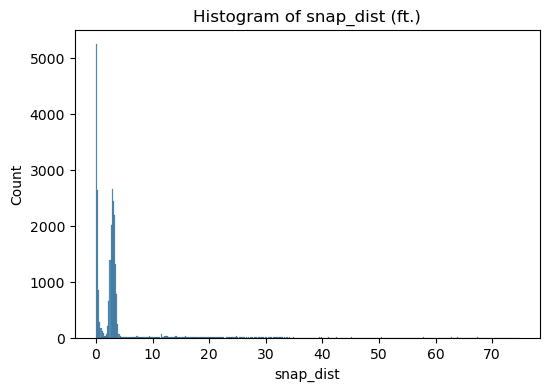

In [26]:
# distribution of snap distances
plt.figure(figsize=(6, 4))

sns.histplot(updated_points['snap_dist'])
plt.title('Histogram of snap_dist (ft.)')

In [27]:
# examine counts per street id
gdf_count = (
    updated_points
    .groupby(by='physicalid')['created_date']
    .count()
    .reset_index()
    .rename(columns={"created_date": "count"})
)

gdf_count.head()

,physicalid,count
0,100019,1
1,100020,1
2,10003,1
3,10004,2
4,100041,1


In [28]:
# join our street data to our flood complaints data
streets_with_count = streets.merge(
    gdf_count, 
    on='physicalid',
    how='left'
)

streets_with_count['count'] = streets_with_count['count'].fillna(0).astype(int)

print(f'shape of data: {streets_with_count.shape}')
streets_with_count.head()

shape of data: (99324, 13)


,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,count
0,3,BATTERY PL,BATTERY,BATTERY PL,1,Street,42.0,13,13,1,262.77781228,"MULTILINESTRING ((979278.595 196555.690, 97929...",0
1,5,BATTERY PL,BATTERY,BATTERY PL,1,Street,42.0,13,13,1,259.415988519,"MULTILINESTRING ((979377.413 196797.951, 97950...",0
2,6,BATTERY PL,BATTERY,BATTERY PL,1,Street,42.0,13,13,1,280.444780871,"MULTILINESTRING ((979503.289 197024.782, 97964...",0
3,8,BATTERY PL,BATTERY,BATTERY PL,1,Street,42.0,13,13,1,32.0701391509,"MULTILINESTRING ((979553.746 196059.826, 97952...",0
4,14,BATTERY PL,BATTERY,BATTERY PL,1,Street,24.0,13,13,1,206.27185039,"MULTILINESTRING ((980288.092 195963.182, 98026...",0


In [29]:
# column info
streets_with_count.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 99324 entries, 0 to 99323
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    99324 non-null  object  
 1   st_label      99324 non-null  object  
 2   st_name       99324 non-null  object  
 3   full_stree    99324 non-null  object  
 4   rw_type       99324 non-null  object  
 5   rw_type_name  99324 non-null  object  
 6   st_width      99324 non-null  object  
 7   frm_lvl_co    99324 non-null  object  
 8   to_lvl_co     99324 non-null  object  
 9   borocode      99324 non-null  object  
 10  shape_leng    99324 non-null  object  
 11  geometry      99324 non-null  geometry
 12  count         99324 non-null  int64   
dtypes: geometry(1), int64(1), object(11)
memory usage: 10.6+ MB


In [30]:
# examine highest counts
streets_with_count.sort_values(by='count', ascending=False).head()

,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,count
76015,93488,157 ST,157,157 ST,1,Street,35.0,13,13,4,499.592808383,"MULTILINESTRING ((1045395.176 182129.994, 1045...",91
36568,44654,MILL RD,MILL,MILL RD,1,Street,60.0,13,13,5,404.81289109,"MULTILINESTRING ((952047.247 142027.744, 95184...",87
18877,23726,141 ST,141,141 ST,1,Street,30.0,13,13,4,678.503924658,"MULTILINESTRING ((1039008.416 188480.641, 1039...",71
85763,109590,SAPPHIRE ST,SAPPHIRE,SAPPHIRE ST,1,Street,22.0,13,13,3,554.170960128,"MULTILINESTRING ((1023856.014 183443.026, 1023...",71
67778,83475,BEDELL ST,BEDELL,BEDELL ST,1,Street,30.0,13,13,4,651.973468023,"MULTILINESTRING ((1043449.919 189921.878, 1043...",63


In [31]:
# normalize counts
streets_with_count['shape_leng'] = streets_with_count['geometry'].length
count_norm = (streets_with_count['count'] / streets_with_count['shape_leng'].replace(0, np.nan) * 100)

# counts per 100 ft
streets_with_count['count_per_100ft'] = round(count_norm, 2)

streets_with_count.head()

,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,count,count_per_100ft
0,3,BATTERY PL,BATTERY,BATTERY PL,1,Street,42.0,13,13,1,262.778330,"MULTILINESTRING ((979278.595 196555.690, 97929...",0,0.0
1,5,BATTERY PL,BATTERY,BATTERY PL,1,Street,42.0,13,13,1,259.416503,"MULTILINESTRING ((979377.413 196797.951, 97950...",0,0.0
2,6,BATTERY PL,BATTERY,BATTERY PL,1,Street,42.0,13,13,1,280.445341,"MULTILINESTRING ((979503.289 197024.782, 97964...",0,0.0
3,8,BATTERY PL,BATTERY,BATTERY PL,1,Street,42.0,13,13,1,32.070147,"MULTILINESTRING ((979553.746 196059.826, 97952...",0,0.0
4,14,BATTERY PL,BATTERY,BATTERY PL,1,Street,24.0,13,13,1,206.256713,"MULTILINESTRING ((980288.092 195963.182, 98026...",0,0.0


In [32]:
# examine values
streets_with_count.loc[:, ['count_per_100ft']].describe()

,count_per_100ft
count,99324.000000
mean,0.095102
std,0.979545
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,228.670000


In [33]:
# sort descending
streets_with_count.sort_values(by='count_per_100ft', ascending=False).head()

,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,count,count_per_100ft
89319,155472,W 228 ST,228,W 228 ST,1,Street,44.0,13,13,1,11.807495,"MULTILINESTRING ((1009588.318 258326.241, 1009...",27,228.67
2264,3350,E 47 ST,47,E 47 ST,1,Street,45.0,13,13,1,36.576249,"MULTILINESTRING ((993217.323 213226.959, 99323...",19,51.95
87173,130213,E 68 ST,68,E 68 ST,1,Street,38.0,13,13,3,15.462558,"MULTILINESTRING ((1007289.058 166879.286, 1007...",6,38.80
18223,22994,SHORE BLVD,SHORE,SHORE BLVD,1,Street,36.0,13,13,4,23.642131,"MULTILINESTRING ((1004233.755 222267.727, 1004...",9,38.07
98528,199921,HERKIMER ST,HERKIMER,HERKIMER ST,1,Street,30.0,13,13,3,17.255823,"MULTILINESTRING ((1011761.619 185801.742, 1011...",6,34.77


# Joining Streets and Counts to Neighborhoods

In [34]:
print(f'shape of data: {updated_points.shape}')
updated_points.head()

shape of data: (24750, 50)


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,cross_street_1,cross_street_2,address_type,...,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,shape_leng,geometry,point,snap_dist
0,34783066,2016-11-15T09:27:00.000,2016-11-15T10:05:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),NaN,NaN,INTERSECTION,...,BRIGHTON AVE,1,Street,30.0,13,13,172.36564876,POINT (958593.988 170854.865),POINT (958594.000 170855.000),0.135523
1,16585559,2010-05-04T09:20:00.000,2010-05-08T09:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),ST PETER'S PL,BEND,ADDRESS,...,RICHMOND TER,1,Street,34.0,13,13,602.593212361,POINT (960713.101 175471.573),POINT (960718.000 175485.000),14.292678
2,18255249,2010-07-13T13:20:00.000,2010-07-13T15:10:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),ST PETER'S PL,BEND,ADDRESS,...,RICHMOND TER,1,Street,34.0,13,13,602.593212361,POINT (960713.101 175471.573),POINT (960718.000 175485.000),14.292678
3,18380954,2010-07-30T11:08:00.000,2010-07-30T11:20:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),DANIEL LOW TER,BEND,ADDRESS,...,BELMONT PL,1,Street,30.0,13,13,432.344943452,POINT (961777.231 173950.696),POINT (961777.000 173953.000),2.315312
4,18449016,2010-08-09T13:49:00.000,2010-08-09T14:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),ST PETER'S PL,BEND,ADDRESS,...,RICHMOND TER,1,Street,34.0,13,13,602.593212361,POINT (960713.101 175471.573),POINT (960718.000 175485.000),14.292678


In [35]:
# column info
updated_points.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24750 entries, 0 to 24749
Data columns (total 50 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   unique_key                      24750 non-null  int64   
 1   created_date                    24750 non-null  object  
 2   closed_date                     24749 non-null  object  
 3   agency                          24750 non-null  object  
 4   agency_name                     24750 non-null  object  
 5   complaint_type                  24750 non-null  object  
 6   descriptor                      24750 non-null  object  
 7   cross_street_1                  21759 non-null  object  
 8   cross_street_2                  21754 non-null  object  
 9   address_type                    24750 non-null  object  
 10  status                          24750 non-null  object  
 11  resolution_description          24747 non-null  object  
 12  resolution_action_

In [36]:
# retrieve specific columns
cols = [
    'unique_key',
    'nta2020',
    'countyfips',
    'ntaname',
    'boroname',
    'borocode',
    'shape_leng',
    'physicalid'
]

streets_with_nta = updated_points.loc[:, cols]

streets_with_nta.head()

,unique_key,nta2020,countyfips,ntaname,boroname,borocode,shape_leng,physicalid
0,34783066,SI0101,085,St. George-New Brighton,Staten Island,5,172.36564876,52392
1,16585559,SI0101,085,St. George-New Brighton,Staten Island,5,602.593212361,44892
2,18255249,SI0101,085,St. George-New Brighton,Staten Island,5,602.593212361,44892
3,18380954,SI0101,085,St. George-New Brighton,Staten Island,5,432.344943452,45070
4,18449016,SI0101,085,St. George-New Brighton,Staten Island,5,602.593212361,44892


In [37]:
# check for duplicates
checking_for_duplicates = (
    streets_with_nta
    .groupby(by=['physicalid', 'ntaname', 'boroname'])['shape_leng']
    .count()
    .reset_index()
    .rename(columns={"shape_leng": "count_complaints"})
)

checking_for_duplicates.head()

,physicalid,ntaname,boroname,count_complaints
0,100019,Howard Beach-Lindenwood,Queens,1
1,100020,Howard Beach-Lindenwood,Queens,1
2,10003,East Elmhurst,Queens,1
3,10004,East Elmhurst,Queens,2
4,100041,Queens Village,Queens,1


In [38]:
is_unique = checking_for_duplicates['physicalid'].is_unique

print(f'street id is unique: {is_unique}')

street id is unique: False


In [39]:
(checking_for_duplicates
 .loc[checking_for_duplicates.duplicated(subset=['physicalid'], keep=False) == True]
 .sort_values(by=['physicalid', 'count_complaints'], ascending=[True, False])
 .head(10)
)

,physicalid,ntaname,boroname,count_complaints
61,10042,Glendale,Queens,5
62,10042,Rego Park,Queens,1
541,10779,Middle Village,Queens,1
542,10779,Middle Village Cemetery,Queens,1
557,109590,Howard Beach-Lindenwood,Queens,53
556,109590,East New York-City Line,Brooklyn,18
585,1128,Chelsea-Hudson Yards,Manhattan,2
586,1128,Midtown-Times Square,Manhattan,2
594,1134,Hell's Kitchen,Manhattan,5
595,1134,Midtown-Times Square,Manhattan,3


In [40]:
count_duplicates = (
    checking_for_duplicates
    .loc[checking_for_duplicates.duplicated(subset=['physicalid'], keep=False) == True]
    .shape[0]
)

counts = round(count_duplicates / streets_with_count.shape[0] * 100, 2)

print(f'count of duplicates: {count_duplicates:,}')
print(f'percent duplicates: {counts}%')

count of duplicates: 130
percent duplicates: 0.13%


In [41]:
# sorting descending by number of complaints on a street in a given NTA then removing duplicates
unique_streets = (
    checking_for_duplicates
    .sort_values(by=['physicalid', 'count_complaints'], ascending=[True, False])
    .drop_duplicates('physicalid')
    .reset_index(drop=True)
)

print(f"physical id is unique: {unique_streets['physicalid'].is_unique}")
unique_streets.head()

physical id is unique: True


,physicalid,ntaname,boroname,count_complaints
0,100019,Howard Beach-Lindenwood,Queens,1
1,100020,Howard Beach-Lindenwood,Queens,1
2,10003,East Elmhurst,Queens,1
3,10004,East Elmhurst,Queens,2
4,100041,Queens Village,Queens,1


In [42]:
# joining streets with count complaints to unique streets
streets_with_count_nta = streets_with_count.merge(
    unique_streets, 
    left_on='physicalid', 
    right_on='physicalid', 
    how='left'
)

print(f'shape of data: {streets_with_count_nta.shape}')
streets_with_count_nta.head()

shape of data: (99324, 17)


,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,count,count_per_100ft,ntaname,boroname,count_complaints
0,3,BATTERY PL,BATTERY,BATTERY PL,1,Street,42.0,13,13,1,262.778330,"MULTILINESTRING ((979278.595 196555.690, 97929...",0,0.0,NaN,NaN,NaN
1,5,BATTERY PL,BATTERY,BATTERY PL,1,Street,42.0,13,13,1,259.416503,"MULTILINESTRING ((979377.413 196797.951, 97950...",0,0.0,NaN,NaN,NaN
2,6,BATTERY PL,BATTERY,BATTERY PL,1,Street,42.0,13,13,1,280.445341,"MULTILINESTRING ((979503.289 197024.782, 97964...",0,0.0,NaN,NaN,NaN
3,8,BATTERY PL,BATTERY,BATTERY PL,1,Street,42.0,13,13,1,32.070147,"MULTILINESTRING ((979553.746 196059.826, 97952...",0,0.0,NaN,NaN,NaN
4,14,BATTERY PL,BATTERY,BATTERY PL,1,Street,24.0,13,13,1,206.256713,"MULTILINESTRING ((980288.092 195963.182, 98026...",0,0.0,NaN,NaN,NaN


In [43]:
# examine columns
streets_with_count_nta.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 99324 entries, 0 to 99323
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   physicalid        99324 non-null  object  
 1   st_label          99324 non-null  object  
 2   st_name           99324 non-null  object  
 3   full_stree        99324 non-null  object  
 4   rw_type           99324 non-null  object  
 5   rw_type_name      99324 non-null  object  
 6   st_width          99324 non-null  object  
 7   frm_lvl_co        99324 non-null  object  
 8   to_lvl_co         99324 non-null  object  
 9   borocode          99324 non-null  object  
 10  shape_leng        99324 non-null  float64 
 11  geometry          99324 non-null  geometry
 12  count             99324 non-null  int64   
 13  count_per_100ft   99324 non-null  float64 
 14  ntaname           11991 non-null  object  
 15  boroname          11991 non-null  object  
 16  count_complain

In [44]:
# retrieve desired columns
cols = [
    'physicalid','full_stree', 'ntaname', 'boroname',
    'count', 'count_per_100ft'
]

count_by_nta = (
    streets_with_count_nta
    .loc[:, cols]
    .reset_index(drop=True)
)

# sort on count desc
count_by_nta.sort_values(by='count', ascending=False).head()

,physicalid,full_stree,ntaname,boroname,count,count_per_100ft
76015,93488,157 ST,Springfield Gardens (South)-Brookville,Queens,91,18.21
36568,44654,MILL RD,Oakwood-Richmondtown,Staten Island,87,21.49
18877,23726,141 ST,Baisley Park,Queens,71,10.46
85763,109590,SAPPHIRE ST,Howard Beach-Lindenwood,Queens,71,12.81
67778,83475,BEDELL ST,Baisley Park,Queens,63,9.66


In [45]:
# sort on count per 100ft desc
count_by_nta.sort_values(by='count_per_100ft', ascending=False).head()

,physicalid,full_stree,ntaname,boroname,count,count_per_100ft
89319,155472,W 228 ST,Kingsbridge-Marble Hill,Bronx,27,228.67
2264,3350,E 47 ST,United Nations,Manhattan,19,51.95
87173,130213,E 68 ST,Marine Park-Mill Basin-Bergen Beach,Brooklyn,6,38.80
18223,22994,SHORE BLVD,Old Astoria-Hallets Point,Queens,9,38.07
98528,199921,HERKIMER ST,Ocean Hill,Brooklyn,6,34.77


In [46]:
# summary statistics
(streets_with_count
 .groupby(by=['physicalid', 'full_stree'])[['count', 'count_per_100ft']]
 .sum()
 .reset_index()
 .describe()
)

,count,count_per_100ft
count,99324.000000,99324.000000
mean,0.249184,0.095102
std,1.310524,0.979545
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,91.000000,228.670000


In [47]:
# Adding nta information
count_by_nta['ntaname_full'] = (
    count_by_nta['full_stree']
    + " (id: "
    + count_by_nta['physicalid']
    + "), " + count_by_nta['ntaname']
    + ", "
    + count_by_nta['boroname']
)

count_by_nta.sort_values(by='count', ascending=False).head()

,physicalid,full_stree,ntaname,boroname,count,count_per_100ft,ntaname_full
76015,93488,157 ST,Springfield Gardens (South)-Brookville,Queens,91,18.21,"157 ST (id: 93488), Springfield Gardens (South..."
36568,44654,MILL RD,Oakwood-Richmondtown,Staten Island,87,21.49,"MILL RD (id: 44654), Oakwood-Richmondtown, Sta..."
18877,23726,141 ST,Baisley Park,Queens,71,10.46,"141 ST (id: 23726), Baisley Park, Queens"
85763,109590,SAPPHIRE ST,Howard Beach-Lindenwood,Queens,71,12.81,"SAPPHIRE ST (id: 109590), Howard Beach-Lindenw..."
67778,83475,BEDELL ST,Baisley Park,Queens,63,9.66,"BEDELL ST (id: 83475), Baisley Park, Queens"


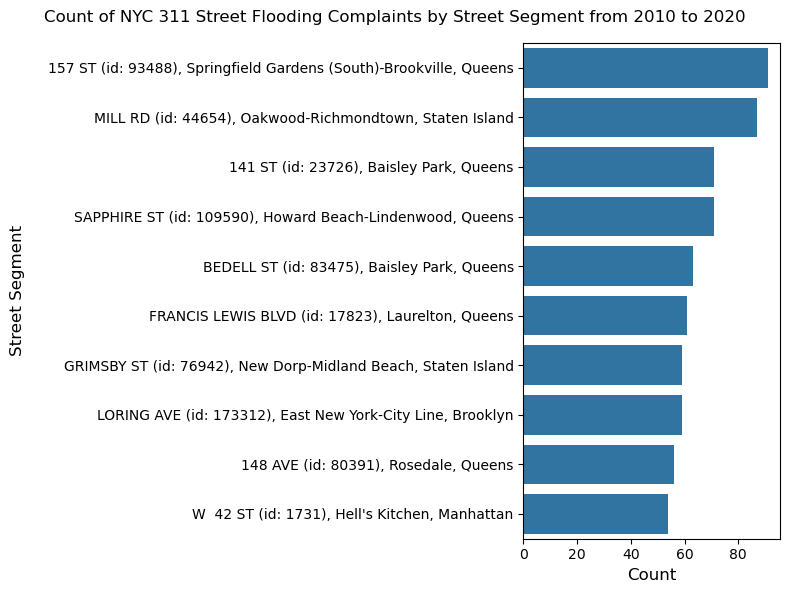

In [48]:
fig, ax = plt.subplots(figsize=(8, 6))

data = count_by_nta.sort_values(by='count', ascending=False).head(10)
sns.barplot(
    data=data,
    y='ntaname_full',
    x='count',
    color='#1f77b4'
)

label = 'Count of NYC 311 Street Flooding Complaints by Street Segment from 2010 to 2020'
fig.suptitle(label, fontsize=12)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Street Segment\n', fontsize=12)

plt.tight_layout()

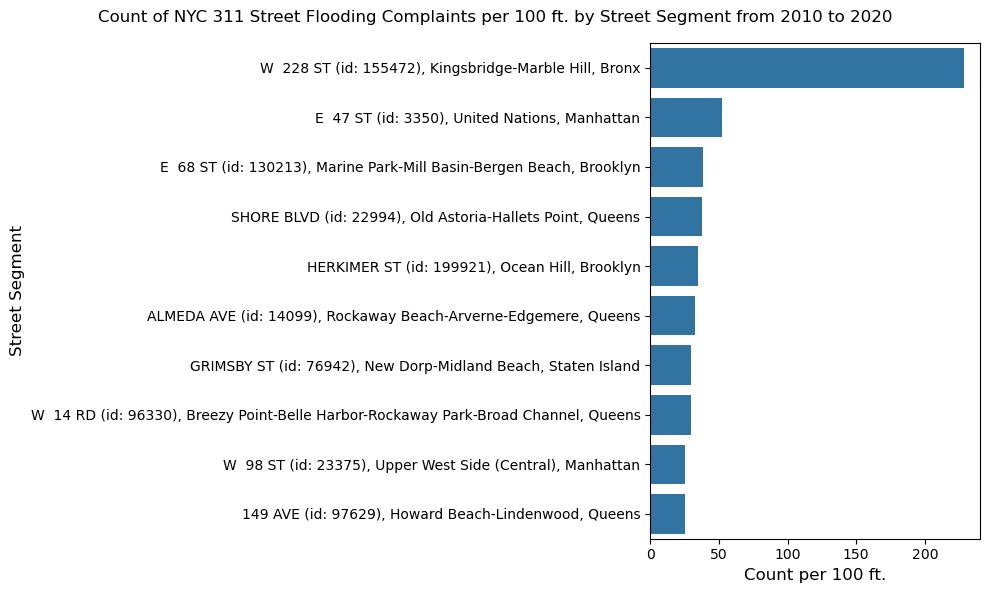

In [49]:
fig, ax = plt.subplots(figsize=(10, 6))

data = count_by_nta.sort_values(by='count_per_100ft', ascending=False).head(10)
sns.barplot(
    data=data,
    y='ntaname_full',
    x='count_per_100ft',
    color='#1f77b4'
)

label = 'Count of NYC 311 Street Flooding Complaints per 100 ft. by Street Segment from 2010 to 2020'
fig.suptitle(label, fontsize=12)
plt.xlabel('Count per 100 ft.', fontsize=12)
plt.ylabel('Street Segment', fontsize=12)

plt.tight_layout()

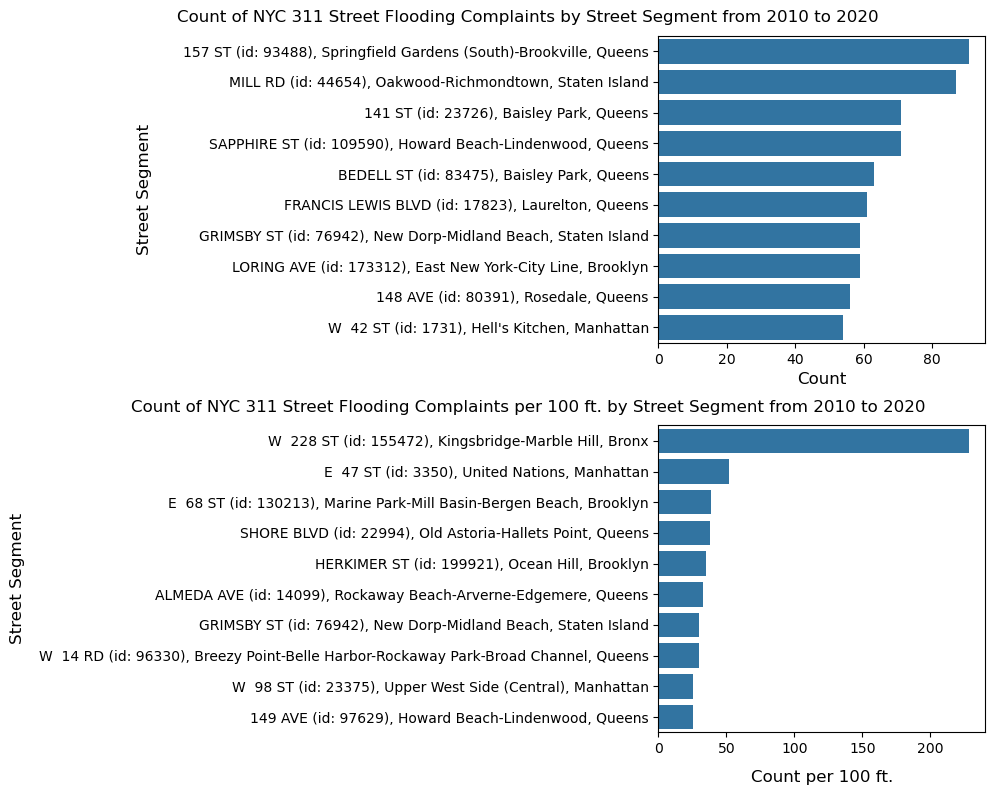

In [50]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# first plot
data = count_by_nta.sort_values(by='count', ascending=False).head(10)
sns.barplot(
    data=data,
    y='ntaname_full',
    x='count',
    color='#1f77b4',
    ax=axs[0]
)

label = 'Count of NYC 311 Street Flooding Complaints by Street Segment from 2010 to 2020'
axs[0].set_title(label, fontsize=12, pad=10, x=-.4)
axs[0].set_xlabel('Count', fontsize=12)
axs[0].set_ylabel('Street Segment\n', fontsize=12, labelpad=10)

# second plot
data = count_by_nta.sort_values(by='count_per_100ft', ascending=False).head(10)
sns.barplot(
    data=data,
    y='ntaname_full',
    x='count_per_100ft',
    color='#1f77b4',
    ax=axs[1]
)

label = 'Count of NYC 311 Street Flooding Complaints per 100 ft. by Street Segment from 2010 to 2020'
axs[1].set_title(label, fontsize=12, pad=10, x=-.4)
axs[1].set_xlabel('Count per 100 ft.', fontsize=12, labelpad=10)
axs[1].set_ylabel('Street Segment', fontsize=12, labelpad=10)

fig.tight_layout(pad=.9)
plt.savefig('figures/count-street-segment.png', dpi=250, bbox_inches='tight')